In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn.datasets import make_blobs
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans

Initalize Centroids

In [2]:
def init_centroids_kmeanspp(X, k):
    n = X.shape[0]
    centroids = np.zeros((k, X.shape[1]))
    centroids[0] = X[np.random.randint(0, n)]
    for i in range(1, k):
        distances = np.min([np.linalg.norm(X - centroids[j], axis=1)**2 for j in range(i)], axis=0)
        prob = distances / distances.sum()
        centroids[i] = X[np.random.choice(n, p=prob)]

    return centroids

Intialize Distance, Weight, Partition Matrixes

In [3]:
def init_matrices(m,n,k):
    D=np.zeros(m)
    U=np.zeros((n,k))
    W_D=np.zeros((n,k))

    return D,U,W_D

Intialize Weights

In [10]:
def init_weights(m):
    W=np.zeros(m)
    for i in range(m):
        W[i]=1/m
    return W

Basic Functions

In [4]:
def dist(X,Z,i,j,l):
    return(X[i,j]-Z[l,j])**2

def compute_W_D_i_l(m,beta,X,Z,W,i,l):
    distm=0
    for j in range(m):
        distm+=(W[j]**beta)*dist(X,Z,i,j,l)
    return distm

def modify_W_D(n,k,m,beta,X,Z,W,W_D):
    for i in range(n):
        for l in range(k):
            W_D[i,l]=compute_W_D_i_l(m,beta,X,Z,W,i,l)

Find The Minimum Weighted Distance

In [5]:
def find_min_W_D(W_D,i,k):
    min_index=0
    min=W_D[i,0]
    for l in range(k):
        if min>W_D[i,l]:
            min=W_D[i,l]
            min_index=l
    return min_index

Modify Partition Matrix

In [6]:
def modify_U(n,k,U,W_D):
    for i in range(n):
        min_dist=find_min_W_D(W_D,i,k)
        for l in range(k):
            if l!=min_dist:
                U[i,l]=0
            else:
                U[i,l]=1

Modify Centroid Matrix

In [7]:
def modify_Z(n,k,m,X,Z,U):
    for l in range(k):
        for j in range(m):
            num=0
            den=0
            for i in range(n):
                num+=U[i,l]*X[i,j]
                den+=U[i,l]
            if den!=0:
                Z[l,j]=num/den

Modify Distance Matrix

In [8]:
def modify_D(n,k,m,X,U,Z,D):
    for j in range(m):
        D[j]=0
        for l in range(k):
            for i in range(n):
                D[j]+=U[i,l]*dist(X,Z,i,j,l)

Find Minimum Distance Index

In [9]:
def find_min_D(m,D):
    min_index=0
    min=D[0]
    for j in range(m):
        if min>D[j]:
            min=D[j]
            min_index=j
    return min_index

Modify Weight Matrix

In [11]:
def modify_W(m,beta,W,D):
    if beta==1:
        find_mn=find_min_D(m,D)
        for j in range(m):
            if j==find_mn:
                W[j]=1
            else:
                W[j]=0
    elif beta<=0 or beta >1:
        for j in range(m):
            if D[j] == 0:
                W[j] = 0.0
            else:
                denom = 0.0
                for t in range(m):
                    if D[t] != 0:
                        denom += (D[j] / D[t]) ** (1.0 / (beta - 1.0))
                W[j] = 1.0 / denom

        s = sum(W)
        if s != 0:
            for j in range(m):
                W[j] /= s
    else:
        raise Exception("The value of beta is not valid")

KMeans

In [12]:
def K_Means(n,k,m,X,beta,max_iter):
    # Random Intialization
    Z=init_centroids_kmeanspp(X,k)
    W=init_weights(m)
    D,U,W_D=init_matrices(m,n,k)
    # Break Point
    modify_W_D(n,k,m,beta,X,Z,W,W_D)
    modify_U(n,k,U,W_D)
    modify_D(n,k,m,X,U,Z,D)
    modify_W(m,beta,W,D)
    i=0
    prev_U = np.copy(U)
    while (i<max_iter):
        modify_Z(n,k,m,X,Z,U)
        for l in range(k):
            if np.all(U[:, l] == 0):
                Z[l] = X[np.random.randint(0, n)]
        modify_W_D(n,k,m,beta,X,Z,W,W_D)
        modify_U(n,k,U,W_D)
        modify_D(n,k,m,X,U,Z,D)
        modify_W(m, beta, W, D)
        if np.array_equal(U, prev_U):
            print(f"Converged at iteration {i}.")
            break

        prev_U = np.copy(U)
        i += 1

    obj = 0.0
    for j in range(m):
        obj += (W[j] ** beta) * D[j]

    return Z,W,U,i,obj

Plot The Clustering

In [13]:
def show_clusters(X, cluster, cg):
    df = DataFrame(dict(x=X[:, 0], y=X[:, 1], label=cluster))

    num_clusters = len(np.unique(cluster))
    cmap = plt.cm.get_cmap('tab20', num_clusters)  # Supports up to 20 unique colors

    fig, ax = plt.subplots(figsize=(8, 8))

    for key in np.unique(cluster):
        color = cmap(key % 20)  # cycle through colors if >20 clusters
        points = df[df['label'] == key]
        ax.scatter(points['x'], points['y'], label=f'Cluster {key}', color=color, s=40)

    # Plot centroids
    ax.scatter(cg[:, 0], cg[:, 1], marker='*', s=200, c='red', edgecolors='black', label='Centroids')

    plt.xlabel('X₁')
    plt.ylabel('X₂')
    plt.title(f'K-Means Clustering Result ({num_clusters} Clusters)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

Example Implementation

Converged at iteration 21.
✅ Weighted K-Means ARI: 0.3731
🔹 Standard K-Means ARI: 0.3469
Feature Weights (W): [0.006 0.993 0.001]
Converged in 21 iterations


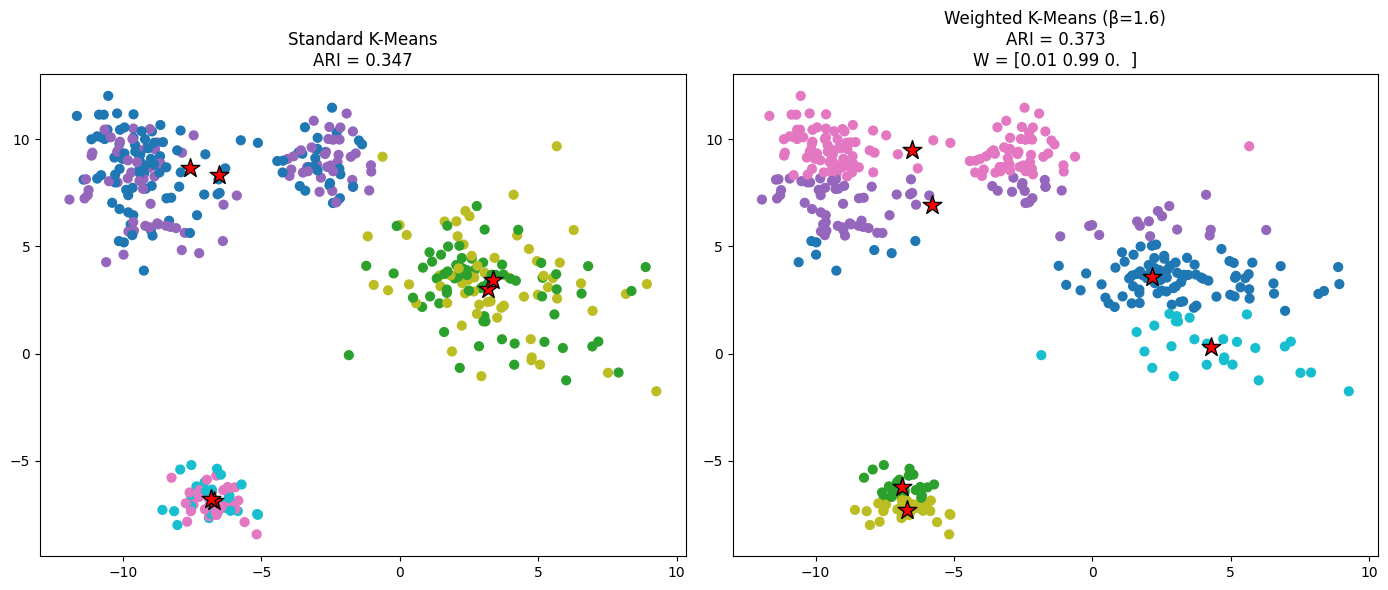

In [20]:
X, y_true = make_blobs(
    n_samples=400,
    centers=6,
    cluster_std=[1.0, 2.0, 0.8, 1.5, 1.2, 1.0],  # ✅ 6 std values
    random_state=42
)

# Add irrelevant noisy feature
noise = np.random.uniform(-10, 10, size=(X.shape[0], 1))
X = np.hstack([X, noise])

n, m = X.shape
k = 6
beta = 1.6
max_iter = 100

# --- Weighted K-Means ---
Z, W, U, iters, obj = K_Means(n, k, m, X, beta, max_iter)
cluster_custom = np.argmax(U, axis=1)

# --- Standard K-Means ---
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_kmeans = kmeans.fit_predict(X)

# --- Evaluation ---
ari_custom = adjusted_rand_score(y_true, cluster_custom)
ari_kmeans = adjusted_rand_score(y_true, cluster_kmeans)

print("✅ Weighted K-Means ARI:", round(ari_custom, 4))
print("🔹 Standard K-Means ARI:", round(ari_kmeans, 4))
print("Feature Weights (W):", np.round(W, 3))
print("Converged in", iters, "iterations")

# --- Visualization ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Standard K-Means
axes[0].scatter(X[:, 0], X[:, 1], c=cluster_kmeans, cmap='tab10', s=40)
axes[0].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
                marker='*', s=200, c='red', edgecolors='black')
axes[0].set_title(f"Standard K-Means\nARI = {ari_kmeans:.3f}")

# Weighted K-Means
axes[1].scatter(X[:, 0], X[:, 1], c=cluster_custom, cmap='tab10', s=40)
axes[1].scatter(Z[:, 0], Z[:, 1], marker='*', s=200, c='red', edgecolors='black')
axes[1].set_title(f"Weighted K-Means (β={beta})\nARI = {ari_custom:.3f}\nW = {np.round(W,2)}")

plt.tight_layout()
plt.show()